In [1]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math

##### Fetch Live stock data 

In [2]:
stock = yf.Ticker("CESC.NS")
data = stock.history(period="3y", interval="1d")

data.index = data.index.date  # converts to plain date (datetime.date object)
# Select only numerical columns and round to 2 decimal places
data = data.round(2)
# ṛemoving not needed columns from the data
data = data[["Close", "Open" , "Low" , "High" , "Volume"]]

In [3]:
print("Stock Price of last 5 days :::")
data.tail()

Stock Price of last 5 days :::


,Close,Open,Low,High,Volume
2025-08-04,163.80,166.13,162.51,166.86,2479637
2025-08-05,164.27,164.20,162.50,167.07,2211894
2025-08-06,161.52,164.27,161.23,165.44,2795400
2025-08-07,165.84,161.40,160.50,170.27,18187448
2025-08-08,163.19,166.15,162.01,166.24,2642597


##### Neccesary Data pre-processing steps 

In [4]:
# check for missing values
print("Missing values in data >>>\n")
data.isna().sum()

Missing values in data >>>



Close     0
Open      0
Low       0
High      0
Volume    0
dtype: int64

In [5]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe())

summary statistics  
             Close        Open         Low        High        Volume
count  742.000000  742.000000  742.000000  742.000000  7.420000e+02
mean   118.351011  118.487493  116.464380  120.512749  5.352938e+06
std     45.340443   45.419241   44.380197   46.372999  6.363200e+06
min     59.420000   59.660000   58.390000   61.260000  0.000000e+00
25%     69.850000   69.792500   69.012500   70.690000  2.021745e+06
50%    124.940000  125.305000  122.200000  127.540000  3.626648e+06
75%    163.052500  163.385000  160.845000  166.065000  6.162648e+06
max    202.320000  202.800000  196.700000  206.280000  7.028120e+07


##### Stock Price Visualization 

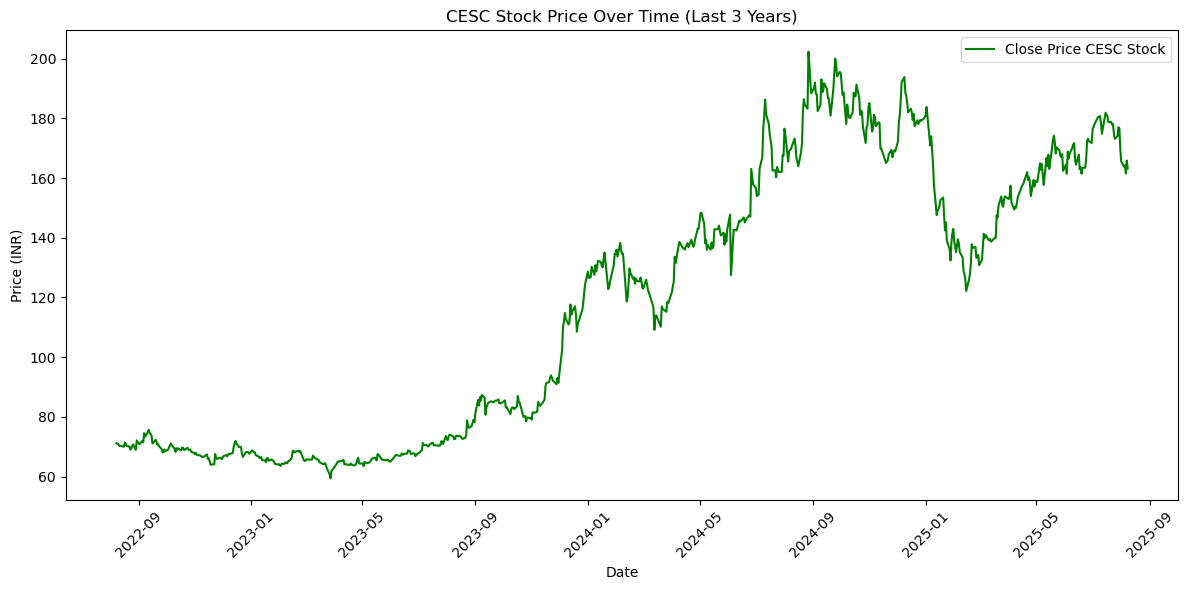

In [6]:
# stock price over the time using line chart
plt.figure(figsize=(12, 6))
sb.lineplot(data=data, x=data.index, y="Close", label="Close Price CESC Stock" , color="green")
plt.title("CESC Stock Price Over Time (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

##### Scatter plot shows the association between two variable (how much they're depended)

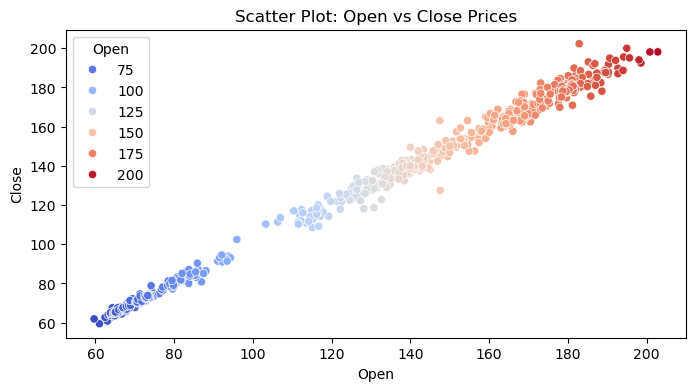

In [7]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

##### Heatmap shows the correlations of all the numerical cols and shows how all are connected

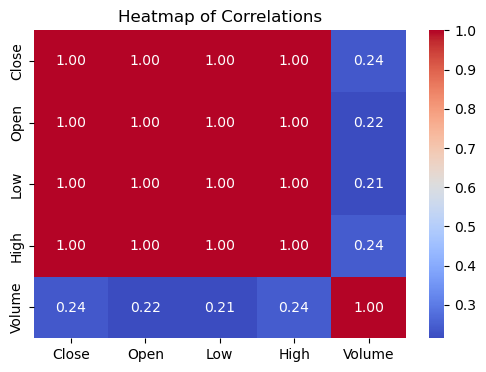

In [8]:
numeric_cols = data.select_dtypes(include=['float64', 'int64'])
# heatmap for visualizing relationships between numerical columns
plt.figure(figsize=(6, 4))
sb.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Correlations")
plt.show()

###### Rule of thumb:-
- 0.5 < skew < 0.5 → fairly symmetrical
- Otherwise → consider transformation

In [9]:
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))
print("Skewness (Volume):", skew(data['Volume']))

Skewness (Close): 0.12385275737756613
Skewness (Open): 0.12651616800850857
Skewness (High): 0.11839712331089683
Skewness (Low): 0.1369273299271371
Skewness (Volume): 4.647166151140587


#### Skewness Analysis 
- Close = 0.124 -> 	Almost symmetrical — no serious skew.
- Open = 0.127 -> 	Almost symmetrical — no serious skew.
- High = 0.118 -> 	Almost symmetrical — no serious skew.
- Low = 0.137 -> 	Almost symmetrical — no serious skew.
- Volume = 4.647 -> Highly positively skewed — heavy right tail (some days have extremely high volume compared to others).

In [10]:
# Volume:
# Extremely skewed — a few trading days have unusually high volumes.
# This can cause LSTM to overemphasize rare spikes.
# Solution : Log transformation to reduce skewness.

## As of now, we are not using volume in our model, but if we do, we can apply log transformation to reduce skewness in future. 

In [11]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [12]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
data.tail()

Overview of dataset after adding some features 




,Close,Open,Low,High,Volume,Trend
2025-08-04,163.80,166.13,162.51,166.86,2479637,1
2025-08-05,164.27,164.20,162.50,167.07,2211894,0
2025-08-06,161.52,164.27,161.23,165.44,2795400,1
2025-08-07,165.84,161.40,160.50,170.27,18187448,0
2025-08-08,163.19,166.15,162.01,166.24,2642597,0


### LSTM MODEL

##### 1️⃣ Preparing Your Data for LSTM
###### LSTMs expect 3D input: [samples, timesteps, features]
where
```
samples = number of training examples
timesteps = how many past days to look back
features = number of columns (Open, High, Low, Close, Volume)
```

Step 1: Apply transformations & scaling

In [13]:
# Scale all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

Step 2: Create sequences(timesteps)

In [14]:
def create_sequences(dataset, time_steps=90):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps)])  # past 60 days
        y.append(dataset[i + time_steps, 0])   # 'Close' is 1st column here
    # Convert to numpy arrays for better performance with LSTM
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)


Step 3: Train-test split (no shuffle)

In [15]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (545, 60, 6), (545,)
Testing data shape: (137, 60, 6), (137,)


Step 4: LSTM model (Keras - RNN variant) 

In [16]:
model = Sequential()
model.add(
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predict close price

model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

c:\Devs\anaconda_navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.1020 - val_loss: 0.0110
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0075 - val_loss: 0.0044
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0057 - val_loss: 0.0032
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0042 - val_loss: 0.0079
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.

Model evaluation metrics

In [17]:
# Predictions
y_pred = model.predict(X_test)
# Inverse transform (to get actual prices back)
# y_test and y_pred are scaled — need to bring them back

# Create empty array for inverse scaling
y_test_inv = np.zeros((len(y_test), scaled_data.shape[1]))
y_pred_inv = np.zeros((len(y_pred), scaled_data.shape[1]))

# Put the close price predictions back in the correct column
y_test_inv[:, 3] = y_test
y_pred_inv[:, 3] = y_pred[:, 0]

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test_inv)[:, 3]
y_pred_inv = scaler.inverse_transform(y_pred_inv)[:, 3]


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


In [18]:
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 score:", r2)

RMSE: 5.750445873782677
MAE: 4.706331825518141
R2 score: 0.8700898500590093


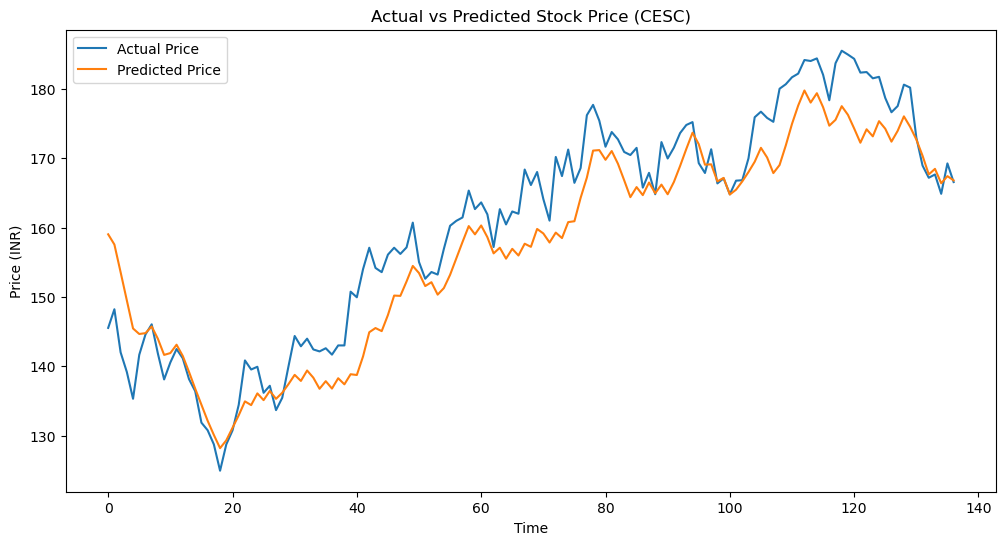

In [19]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price')
plt.title("Actual vs Predicted Stock Price (CESC)")
plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()